# TEST TECHNIQUE - DESCARTES UNDERWRITING


Nina ACHACHE - 18 janvier 2021

## Rappel du sujet

L’objectif du projet est deconstruire un code structuré et fonctionnel en python. Ce code doit permettre de faire une prédiction sur le jeu de données AutoInsurance disponible sur https://www.kaggle.com/c/auto-insurance-fall-2017/data qui a pour cible TARGET_FLAG. 

Ce code devra donner explicitement la valeur de la performance des algorithmes employés  avec une métrique adaptée et produire un fichier au format csv avec les prédictions. 

La performance n’est pas l’élément le plus important. L’objectif du projet est de rédiger les étapes principales d’un projet de data-science en 2 heures de travail en soignant la mise en forme et les commentaires. Il faudra nous transmettre le code sous la forme de fichiers python ou ipythonnotebook utilisant les librairies adaptées par un lien vers un repo github.

Organisation du travail réalisé :
1. Récupération des données
2. Prétraitements & analyse des données
3. Prédiction de Target_FLAG
4. Prédiction de Target_AMT
5. Prédiction fichier test

## Import de bibliothèque


In [1]:
# External import

import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import sklearn.ensemble as ens
from sklearn.linear_model import LinearRegression


## 1. Récupération des données


Je récupère les données dans 2 dataframes :
- le dataframe d'entrainement df_train
- le dataframe de test df_test

In [2]:
#input_path = './Test_Descartes_Underwriting/'

# La première colonne des fichiers csv correspond à l'identifiant unique de la demande d'indémnisation.
df_train = pd.read_csv('train_auto.csv', sep=',',index_col=0)  
df_test = pd.read_csv("test_auto.csv", sep=',',index_col=0)

## 2. Prétraiement & analyse des données

Le training set contient 8161 lignes (ie demandes d'indémnisation) et 25 colonnes.
Les colonnes identifiant, Target_flag et Target_Amt ne sont pas des varaibles. 

On a donc 22 variables dont :

 - 4 variables continues exprimées en dollars : INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM
 - 6 variables catégorielles à 2 catégories : PARENT1, MSTATUS, SEX, CAR_USE, RED_CAR, REVOKED, URBANICITY
 - 3 variables à plus de 2 catégories : JOB, EDUCATION, CAR_TYPE
 - 9 autres variables ne nécéssitant pas de prétraitement
 
On réalise 3 prétraitements différents pour les 3 premiers types de variables. 

On supprime ensuite les lignes contenant des variables manquantes. 

**Pistes pour la gestion des variables manquantes :**
- On remplace les données manquantes par les moyennes ou catégories majoritaires
- On réalise des prédictions à partir des autres variables.

**Fonction de prétraitement :**

In [3]:
def pretraitement(input_df):
    
    # 2.1 Prétraitement des colonnes dont les valeurs sont en dollars
    def function_dollars(x): # fonction permettant de transformer un string en dollars en un float.
        if not pd.isna(x):
            x=float(x[1:].replace(',','.'))
        return(x)

    L_dollars=['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM'] # Liste des colonnes dont les données sont des strings en dollars.
    for c in L_dollars:
        input_df[c] = input_df[c].apply(function_dollars)

    # 2.2 Prétraitement variables catégorielles à 2 catégories

    input_df.PARENT1=input_df.PARENT1.eq('Yes').mul(1)
    input_df.MSTATUS=input_df.MSTATUS.eq('Yes').mul(1)
    input_df.SEX=input_df.SEX.eq('z_F').mul(1)
    input_df.CAR_USE=input_df.CAR_USE.eq('Private').mul(1)
    input_df.RED_CAR=input_df.RED_CAR.eq('yes').mul(1)
    input_df.REVOKED=input_df.REVOKED.eq('Yes').mul(1)
    input_df.URBANICITY=input_df.URBANICITY.eq('Highly Urban/ Urban').mul(1)

    # 2.3 Prétraitement variables catégorielles à plus de 2 catégories

    # EDUCATION
    L_education_type=['z_High School','<High School','Bachelors','Masters','PhD']
    def function_education(x):
        x = L_education_type.index(x)
        return(x)
    # JOB
    L_job_type=['Professional','z_Blue Collar','Clerical', 'Doctor','Home Maker', 'Manager','Student','Lawyer']
    def function_job(x):
        if not pd.isna(x):
            x = L_job_type.index(x)
        return(x)
    # CAR_TYPE
    L_car_type=['Minivan','Van','z_SUV','Panel Truck','Pickup','Sports Car']
    def function_car_type(x):
        x = L_car_type.index(x)
        return(x)

    input_df['EDUCATION'] = input_df['EDUCATION'].apply(function_education)
    input_df['JOB'] = input_df['JOB'].apply(function_job)
    input_df['CAR_TYPE'] = input_df['CAR_TYPE'].apply(function_car_type)

    return(input_df)

**Analyse des distribution de Target_FLAG :**

Training set avant et après suppression des données manquantes :

              rows  columns indémnisation demandée (% d'assurés)  \
avant dropna  8161       25                                26.3%   
après dropna  6045       25                                26.5%   

             indémnisation non demandée (% d'assurés)  
avant dropna                                    73.6%  
après dropna                                    73.4%  


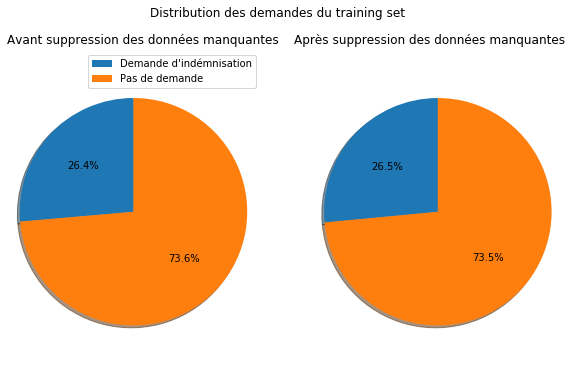

In [4]:
input_df = df_train.copy()
input_df = pretraitement(input_df)

# Avant supression des données manquantes
num_one = len(input_df[input_df.TARGET_FLAG == 1].index)  #nombre de demande d'indémnisation
num_zero = len(input_df[input_df.TARGET_FLAG == 0].index) #nombre d'absence de demande d'indémnisation
Y = [num_one/(num_one + num_zero), num_zero/(num_one + num_zero)] #liste des proportions

# on crée un data frame rassemblant ces informations pour les afficher de manière simple
df1=pd.DataFrame([[input_df.shape[0],input_df.shape[1],str(Y[0]*100)[:4]+"%",str(Y[1]*100)[:4]+"%"]], 
                 index = ["avant dropna"], 
                 columns=['rows','columns',"indémnisation demandée (% d'assurés)","indémnisation non demandée (% d'assurés)"])

# Après supression des données manquantes
input_df=input_df.dropna() 

num_one_bis = len(input_df[input_df.TARGET_FLAG == 1].index) 
num_zero_bis = len(input_df[input_df.TARGET_FLAG == 0].index)
Y_bis = [num_one_bis/(num_one_bis + num_zero_bis), num_zero_bis/(num_one_bis + num_zero_bis)]

df2=pd.DataFrame([[input_df.shape[0],input_df.shape[1],str(Y_bis[0]*100)[:4]+"%",str(Y_bis[1]*100)[:4]+"%"]], 
                 index = ["après dropna"], 
                 columns=['rows','columns',"indémnisation demandée (% d'assurés)","indémnisation non demandée (% d'assurés)"])

# Bilan des informations
df=df1.append(df2) #tableau résumé

print("Training set avant et après suppression des données manquantes :")
print('')
print(df)

# Affichage sous forme de graph
fig, axs = plt.subplots(1,2,figsize=(10, 6))
labels = "Demande d'indémnisation", "Pas de demande"

# Figure avant suppression des varaibles manquantes
axs[0].pie(Y, autopct='%1.1f%%',shadow=True, startangle=90)
axs[0].axis('equal')  # Pour que la figure soit bien un cercle.
axs[0].set_title('Avant suppression des données manquantes',loc='left')

# Figures après suppression des variables manquantes 
axs[1].pie(Y_bis, autopct='%1.1f%%', shadow=True, startangle=90)     
axs[1].axis('equal')  # Pour que la figure soit bien un cercle.
axs[1].set_title('Après suppression des données manquantes',loc='right')

# Affichage
axs[0].legend(labels)
fig.suptitle('Distribution des demandes du training set')
plt.show()

Les distributions de demandes d'indémnisation sont quasi identiques avant et après suppression des données manquantes. On peut donc penser que la suppression des données manquantes ne biaisera pas trop la prédiction.

Si on utilise un modèle naïf prédisant que la demande d'indémnisation n'est jamais faite, alors on aura environ 26% d'erreur. Cela donne un premier élèment de comparaison pour notre modèle.  


## 3. Modèle de prédiction de TARGET_FLAG

**Rappel du sujet :**

On souhaite faire une prédiction sur l'indéminisation d'un véhicule.

Dans un premier temps, on doit faire une prédiction sur **TARGET_FLAG**, variable 
correspondant à la demande d'indéminisation (0 pas de demande, 1 demande). 
On est dans le cadre d'un problème de prédiction supervisée, bi-classe.

Par la suite, on doit faire une prédiction sur la valeur d'indémnisation, contenue dans **TARGET_AMT**.
On est dans un problème regression sur les valeurs de TARGET_AMT pour les cas 
où la variable TARGET_FLAG vaut 1 (indémnisation demandée).

On essaie de réaliser une prédiction en travaillant avec 2 modèles : 
- Une randomn forest 
- Une SVC

In [5]:
input_df = df_train.copy()
input_df = pretraitement(input_df)
input_df=input_df.dropna() 

# 3.1  Définition des training et test set
output_df_flag=input_df.loc[:,'TARGET_FLAG'] #Dataframe contenant les valeurs à prédire.
input_df_flag = input_df.drop(labels=['TARGET_FLAG','TARGET_AMT'], axis=1) #Dataframe contenant les variables.

"""Pour déterminer les performances de nos modèles de prédiction on divise le training set 
en train_set (avec 75% des données) et test_set (contenant les 25% restant)"""
train_feat, test_feat, train_y, test_y = train_test_split(input_df_flag, output_df_flag, test_size=0.25, random_state=111)

# 3.2 Classifiers
# Random Forest
clf_forest_flag = ens.RandomForestClassifier(max_depth=5, random_state=0)
clf_forest_flag.fit(train_feat,train_y)

# SVC
clf_SVC_flag = sklearn.svm.SVC(C=50,decision_function_shape='ovr')#On choisit 50 slack variables pour ne pas en avoir trop par rapport au 1602 cas d'indemnisation.
clf_SVC_flag.fit(train_feat,train_y)

SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

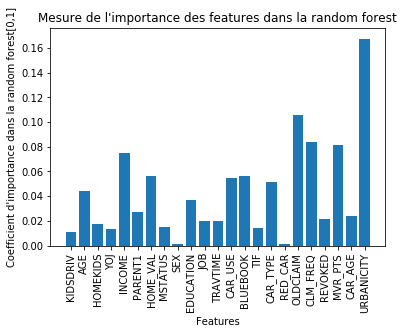

Performance de la random forest
Mean Accuracy :  test set : 0.759 , training set :0.778
Recall : 0.193

Performance de la SVC
Mean Accuracy :  test set : 0.751 , training set :0.763
Recall : 0.161


In [6]:
# 3.3 Résultats et Analyse 

#Importance des features
importance =clf_forest_flag.feature_importances_

plt.bar(input_df_flag.columns, importance)
plt.xticks(rotation=90)
plt.title("Mesure de l'importance des features dans la random forest")
plt.xlabel("Features")
plt.ylabel("Coefficient d'importance dans la random forest[0,1]")
plt.show()

# Résultats Random F
Res_test= clf_forest_flag.score(test_feat, test_y) # Score = accuracy 
Res_train= clf_forest_flag.score(train_feat, train_y)
R=recall_score(train_y,clf_forest_flag.predict(train_feat),pos_label=1,average='binary') # Recall
print("Performance de la random forest")
print("Mean Accuracy : ", "test set : " +str(Res_test)[:5], ", training set :" +str(Res_train)[:5])
print("Recall : "+str(R)[:5])
print()

# Résultats SVC
Res_test= clf_SVC_flag.score(test_feat, test_y)
Res_train= clf_SVC_flag.score(train_feat, train_y)
R=recall_score(train_y,clf_SVC_flag.predict(train_feat),pos_label=1,average='binary')
print("Performance de la SVC")
print("Mean Accuracy : ", "test set : " +str(Res_test)[:5], ", training set :" +str(Res_train)[:5])
print("Recall : "+str(R)[:5])

**Analyse des résultats :** 

- Importances des Features :
    Dans notre étude, on a 22 variables. On peut donc s'interroger sur l'importance de ces variables dans la prédiction. Le Random forest nous permet d'avoir plus d'information à ce sujet.
- Les performances de la random forest sont meilleures que celles de la SVC. En revanche par rapport à une approche naïve (évoquée plus haut), ce n'est pas satisfaisant. 

- Pour cette prédiction, j'ai utilisé la métrique du Recall pour analyser les performances. On constate que le Recall est proche de zéro au lieu de 1, ce qui signifie que l'on rate beaucoup de demandes d'indémnisation. Les performances sont à retravailler.

## 4. Modèle de prédiction de TARGET_AMT

On travaille ici avec un data set contenant : 1602 lignes.


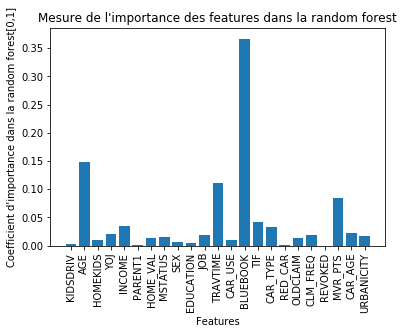

In [7]:
# 4.1  Définition des training et test set
# On séléctionne uniquement les lignes correspondant à des demandes d'indémnisation (ie TARGET_FLAG=1).
index_names = input_df[input_df['TARGET_FLAG'] == 0].index 
input_df=input_df.drop(index_names) 

print("On travaille ici avec un data set contenant : " + str(input_df.shape[0]) + " lignes.")

output_df_amt = input_df.loc[:,'TARGET_AMT'] #Dataframe de ce que l'on souhaite prédire.
input_df_amt = input_df.drop(labels=['TARGET_FLAG','TARGET_AMT'], axis=1) #Dataframe contenant les variables du problème.

# On redéfinit un training et test set.
train_feat_amt, test_feat_amt, train_y_amt, test_y_amt = train_test_split(input_df_amt, output_df_amt, test_size=0.25, random_state=111)

# 4.2 Modèle de prédiction
# Random Forest
clf_forest_amt = ens.RandomForestRegressor(n_estimators=100,max_depth=3, random_state=0)
clf_forest_amt.fit(train_feat_amt,train_y_amt)

# SVR
svr= sklearn.svm.SVR(C=10, epsilon=100) 
svr.fit(train_feat_amt,train_y_amt)

# OLS
lr = LinearRegression()
lr.fit(train_feat_amt,train_y_amt)

#Importance des features
importance_amt = clf_forest_amt.feature_importances_
plt.bar(input_df_amt.columns, importance_amt)
plt.xticks(rotation=90)
plt.title("Mesure de l'importance des features dans la random forest")
plt.xlabel("Features")
plt.ylabel("Coefficient d'importance dans la random forest[0,1]")
plt.show()


**Évaluation des modèle de prédiction :**

In [8]:
#4.3 Analyse des performances
# Random Forest
Res_test_amt = clf_forest_amt.score(test_feat_amt, test_y_amt)
Res_train_amt = clf_forest_amt.score(train_feat_amt, train_y_amt)
prediction=clf_forest_amt.predict(test_feat_amt)
prediction2=clf_forest_amt.predict(train_feat_amt)
erreur_train=prediction2 - train_y_amt
erreur_test=prediction - test_y_amt
print("Erreur médiane - Random forest : training set",str(erreur_train.median())[:6]," , test set ",str(erreur_test.median())[:6]+".")

# SVR
prediction=svr.predict(test_feat_amt)
prediction2=svr.predict(train_feat_amt)
erreur_train=prediction2 - train_y_amt
erreur_test=prediction - test_y_amt
print("Erreur médiane - SVR : training set",str(erreur_train.median())[:6]," , test set ",str(erreur_test.median())[:6] +".")
# OLS
prediction=lr.predict(test_feat_amt)
prediction2=lr.predict(train_feat_amt)
erreur_train=prediction2 - train_y_amt
erreur_test=prediction - test_y_amt
print("Erreur médiane - Regression linéaire OLS : training set",str(erreur_train.median())[:6]," , test set ",str(erreur_test.median())[:6]+".")


Erreur médiane - Random forest : training set 1301.2  , test set  1250.3.
Erreur médiane - SVR : training set 23.972  , test set  -198.4.
Erreur médiane - Regression linéaire OLS : training set 1416.9  , test set  1476.0.


L'erreur médiane de prédiction de la SVR est moins importante que celles de Regression et Random forest. En revanche l'écart entre les erreurs de training et test set laisse penser que la SVR overfit sur les données. Il faudrait retravailler les paramètres de la SVR.

## 5. Prédiction du fichier test.csv

On utilise la random forest pour déterminer TARGET_FLAG puis la SVM pour déterminer le montant d'indémnisation.
Pour ne pas risquer d'overfitter le training set, on travaille avec les modèles entrainés précedement. On avait au préalable vérifier qu'ils n'overfittaient en comparant les scores sur le training set et le test set (très proches).

In [9]:
test_input = pretraitement(df_test)

# Définition des set contenant les features et les variables 
test_input_flag = test_input.drop(labels=['TARGET_FLAG','TARGET_AMT'], axis=1)

test_input_flag=test_input_flag.dropna()
print("Il y a "+ str(test_input_flag.shape[0])+" demandes sans données manquantes.")

# Prédiction de TARGET_FLAG
test_output_flag = clf_forest_flag.predict(test_input_flag)

# Construction du dataset pour la prédiction de TARGET_AMT
test_input_flag['TARGET_FLAG']=test_output_flag.tolist()
test_input_amt=test_input_flag.copy()
index_names = test_input_amt[test_input_amt['TARGET_FLAG'] == 0].index 
test_input_amt=test_input_amt.drop(index_names) 
test_input_amt = test_input_amt.drop(labels=['TARGET_FLAG'], axis=1)

print("Parmis les "+str(test_input_flag.shape[0])+" lignes, il y a " + str(test_input_amt.shape[0]) + " demandes d'indémnisation.")

# Prédiction de TARGET_AMT

test_output_amt=svr.predict(test_input_amt)
test_output_amt=pd.DataFrame(test_output_amt, index=test_input_amt.index, columns=["p_target"])
test_output_amt.to_csv("Predictions_AUTO.csv", sep=',')

Il y a 1612 demandes sans données manquantes.
Parmis les 1612 lignes, il y a 91 demandes d'indémnisation.


Il y a probablement des problèmes de performances au vu du faible nombre de demandes d'indémnisation dans le test set et au vu des scores de recall du modèle de prédiction de TARGET_FLAG.

## Merci pour votre lecture